In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


## Step 1 :Data Reading and Understanding

In [6]:
# import dataset
country_df = pd.read_csv("Country-data.csv")
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [7]:
# shape of dataset
country_df.shape

(167, 10)

In [8]:
# inspecting dataset
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Observation:
- All the features are numeric except the country name
- No missing value are present


In [9]:
country_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Observation:
- Large difference between mean and median, may be due to influence of outlier in  variables child_mort, income and gpdd. Means are almost double of medians


### SubTask 1.2: Percentage to absolute value conversion

In [10]:
# convert percentage value of export , health and imports into its original value
country_df['exports'] = country_df['gdpp']*(country_df['exports']/100)
country_df['imports'] = country_df['gdpp']*(country_df['imports']/100)
country_df['health'] = country_df['gdpp']*(country_df['health']/100)
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


## Step 2: Exploratory Data Analysis
- Since all the columns are numerical except country name, analysis will be mainly done by:
  - box plot
  - histogram
  - scatterplot 
. 

###  SubTask 2.1:Univariate Analysis:
  Identifying *Outliers*

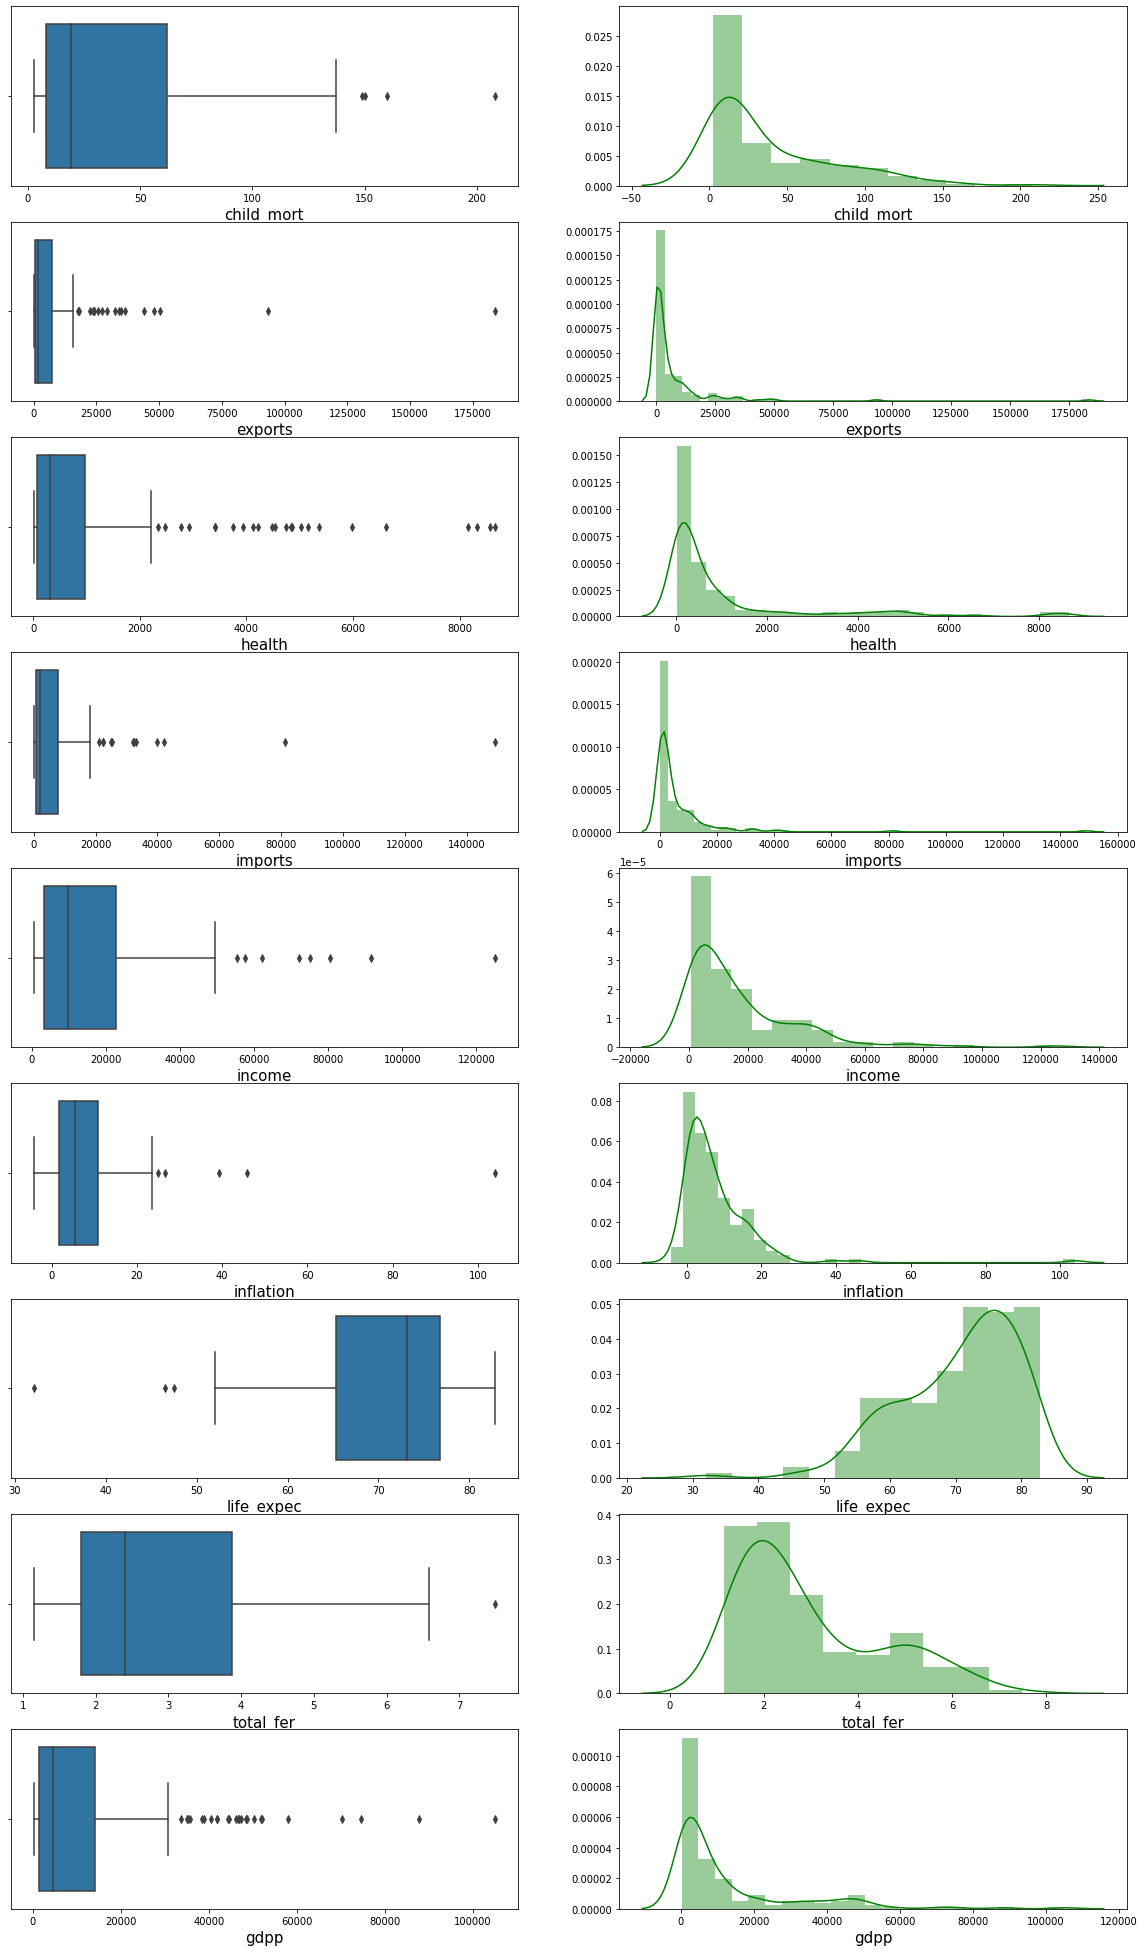

In [11]:
# boxplot and its corresponding histogram:
col = country_df.columns[1:]

fig, axs = plt.subplots(9,2,figsize=[20,35] )
for i in range(len(country_df.columns[1:])):
  
  axs[i,0].set_xlabel(col[i],fontsize = '15')
  sns.boxplot(country_df[col[i]],ax =axs[i,0])
  axs[i,1].set_xlabel(col[i],fontsize = '15')
  sns.distplot(country_df[col[i]],ax= axs[i,1], color = 'green')
plt.show()

Observation:
- __child_mort__ has short range outlier, also high child_mort means that country has high chance of getting aid.So those outliers are important and not to be disturbed.
- __import, export, health, income and gdpp__ have outliers which are quite far,  they mainly symbolise the developed country, which are also not the target countries.So even on capping we will not loose the data for countries which need aid.
- __life expectancy__ has outlier in left side, lower life expectancy again a symbol for countries which need aid.So those outliers are important and not to be disturbed.
- **total-fer** has an outlier which is short range. So it doesnt has much influence. 


### SubTask :
Outlier treatement
  - Outliers of imports, exports, health, income and gdpp will be treated in same ways, as they have simlar issues.
  - Outlier of child_mort will be capped on left end.


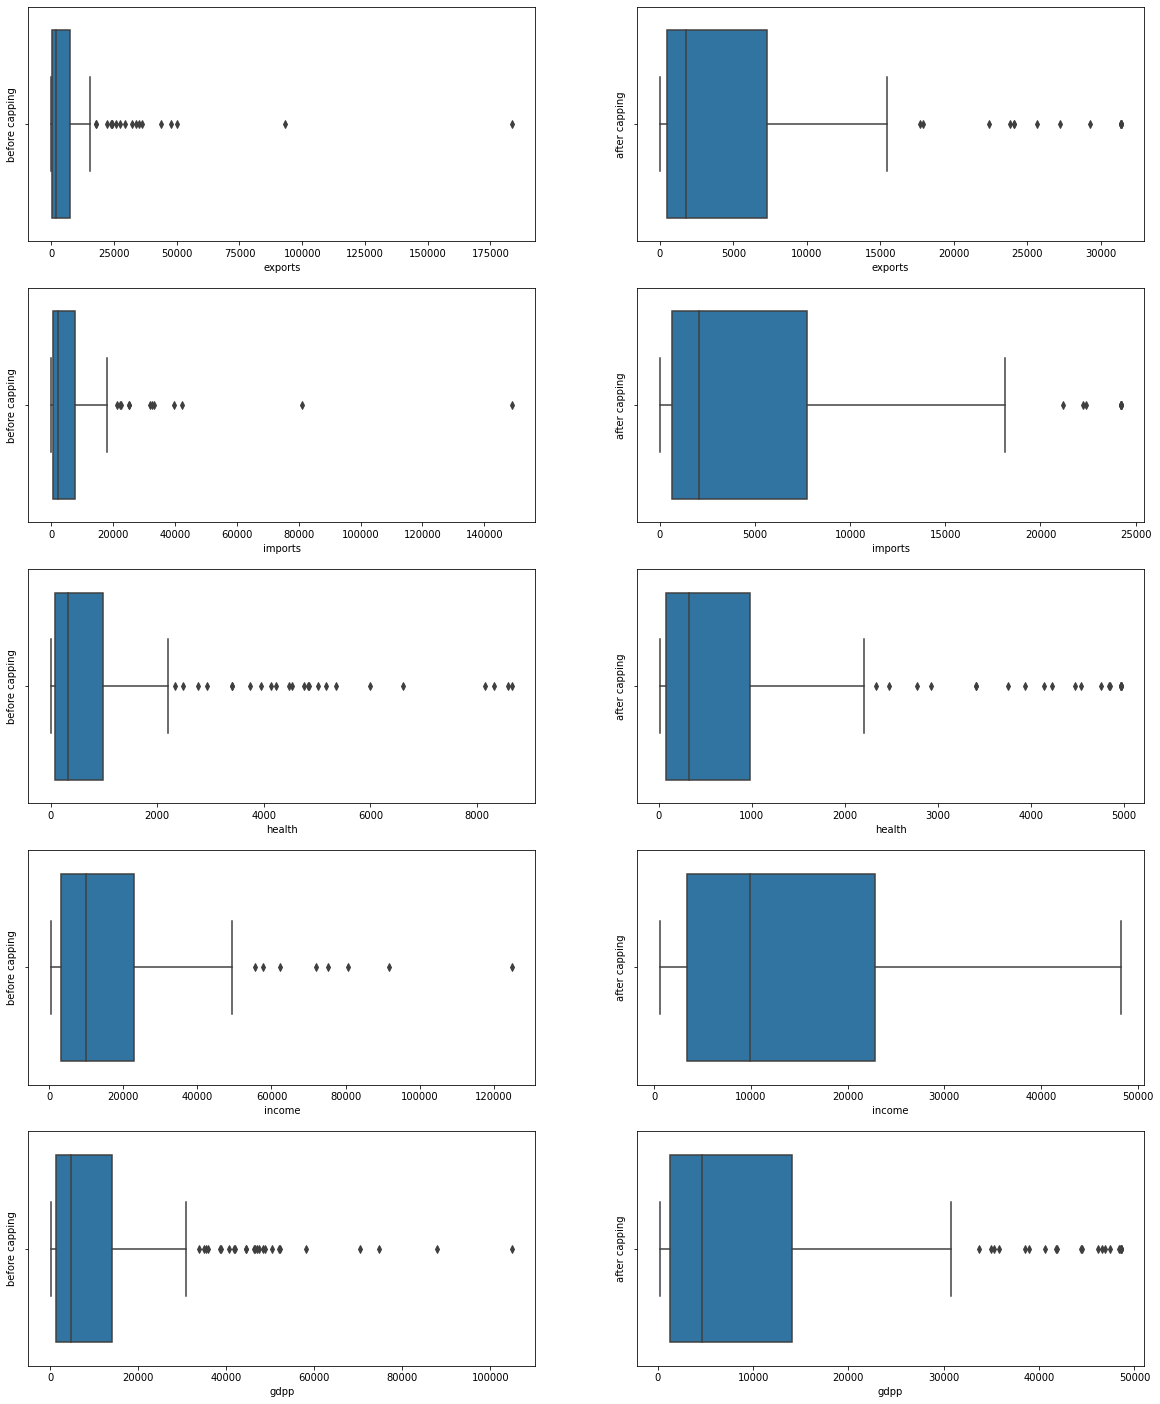

In [12]:
# capping the exports, imports, income, health and gdpp
 
col = ['exports','imports','health','income','gdpp']
fig,axs = plt.subplots(5,2,figsize= [20,25])
for i in range(len(col)):
  axs[i,0].set_ylabel("before capping")
  axs[i,0].set_xlabel(col[i])
  sns.boxplot(country_df[col[i]], ax = axs[i,0])
  q95 = country_df[col[i]].quantile(0.95)
  country_df.loc[country_df[col[i]]> q95,col[i]] = q95
  axs[i,1].set_ylabel("after capping")
  axs[i,1].set_xlabel(col[i])
  sns.boxplot(country_df[col[i]], ax= axs[i,1])

plt.show()



Observation:
- Capping is done till 95%, still some outliers are there, but are not ver far.So we will continue with this much of outliers.

    country  child_mort
68  Iceland         2.6


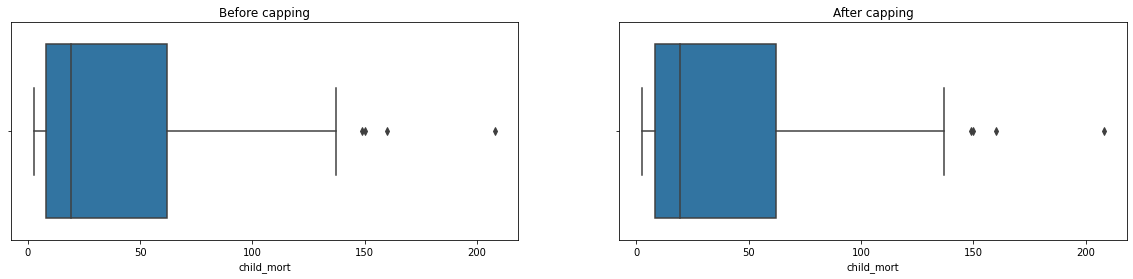

In [13]:
# outlier treatment of child mortatlity
plt.figure(figsize = [20,4])
plt.subplot(1,2,1)
plt.title("Before capping")
sns.boxplot(country_df['child_mort'])
q1 = country_df['child_mort'].quantile(0.01)
print(country_df.loc[country_df['child_mort'] < q1,['country','child_mort']])
country_df.loc[country_df['child_mort'] < q1,'child_mort'] = q1
plt.subplot(1,2,2)
plt.title("After capping")
sns.boxplot(country_df["child_mort"])
plt.show()

###  SubTask 2.1:Bivariate Analysis
Since all the value present are continuous variables, most preferable analysis are
  - Scatteplot 
  - Heatmap

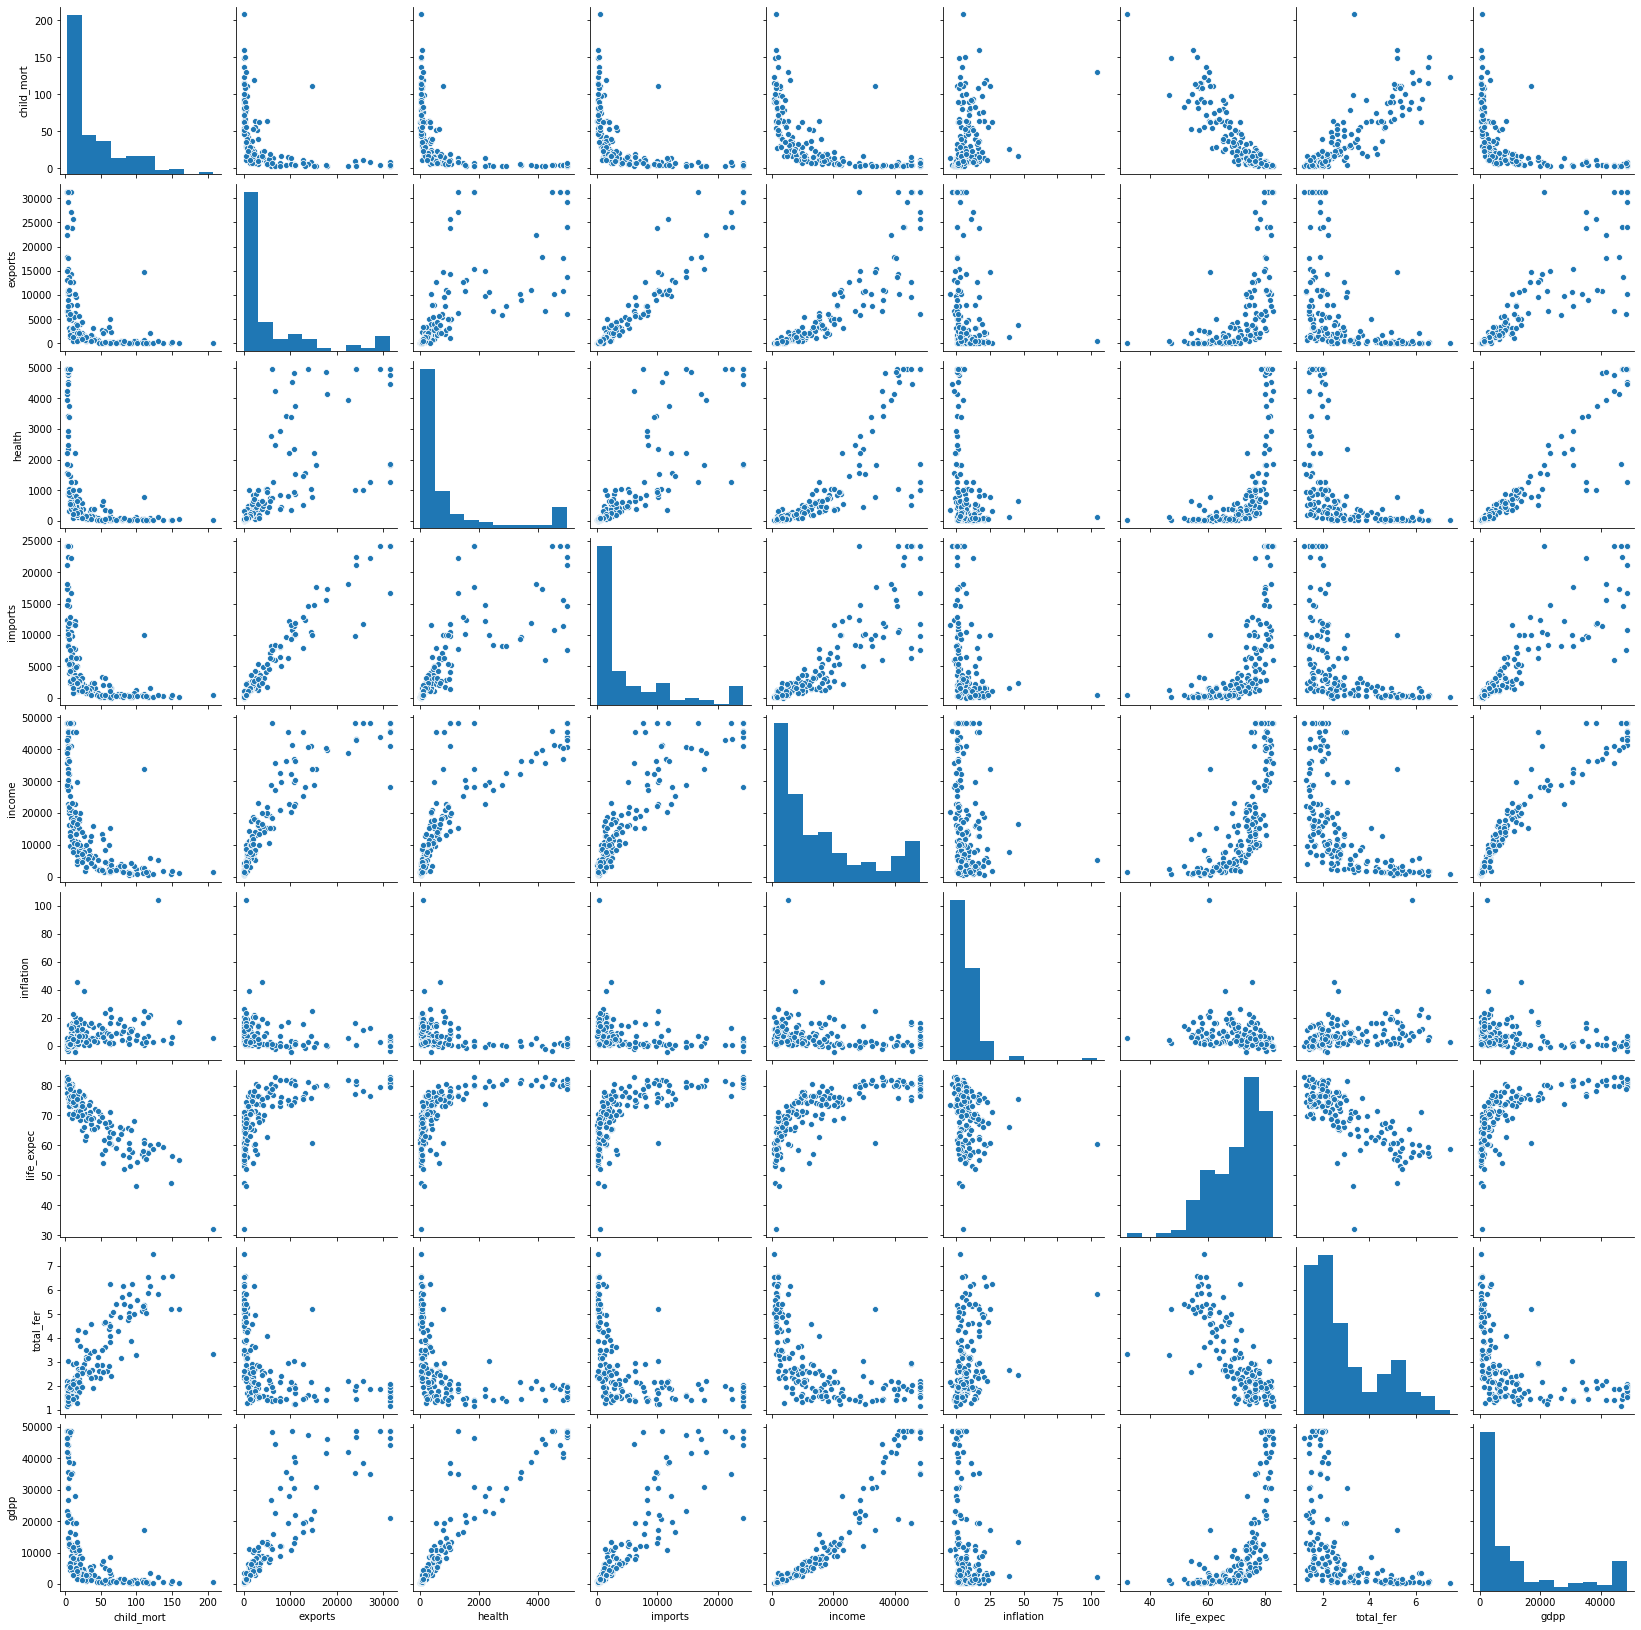

In [14]:
# scatter plot between different features
sns.pairplot(country_df)
plt.show()

Observation:
- Lot of graphs are L shaped, which can be clustered as horizontal , corner and vertical groups 

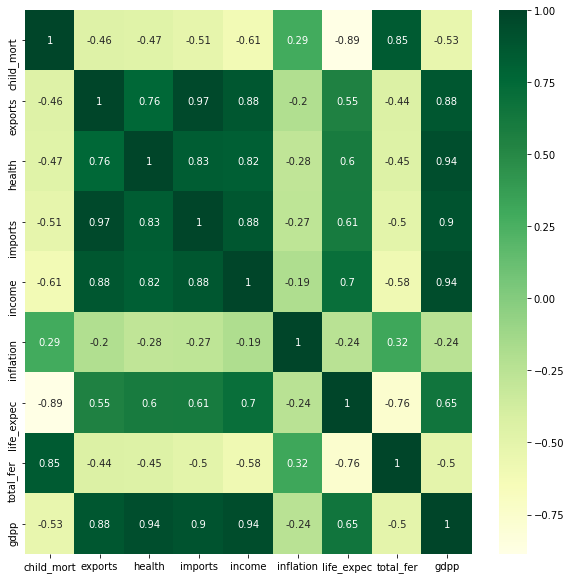

In [16]:
#correlation matrics
plt.figure(figsize = [10,10])
sns.heatmap(country_df.corr(), annot = True , cmap = 'YlGn')
plt.show()

Observation:
  - we can see lot of high correlation values, like :
    - 97% betwen export and import
    - 94% between (health and gdpp),(gdpp- income)
    - 80%  to 90% between (child_mort - total_fer), (child_mort  - life_expectancy)

## Step 3: Clustering

#### SubTask 3.1: Scaling

In [17]:
# scaling
scaler = StandardScaler()
country_df_scaled = scaler.fit_transform(country_df.iloc[:,1:])
country_df_scaled = pd.DataFrame(country_df_scaled,columns = country_df.iloc[:,1:].columns)

country_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.669581,-0.629435,-0.732729,-0.958349,0.157336,-1.619092,1.902882,-0.757362
1,-0.538993,-0.542172,-0.473489,-0.472182,-0.394006,-0.312347,0.647866,-0.859973,-0.523321
2,-0.272870,-0.475838,-0.530017,-0.560152,-0.192552,0.789274,0.670423,-0.038404,-0.498838
3,2.007831,-0.418960,-0.588935,-0.543087,-0.667360,1.387054,-1.179234,2.128151,-0.560376
4,-0.695682,-0.027134,-0.150685,0.306422,0.227992,-0.601749,0.704258,-0.541946,0.013312


In [18]:
# inspecting the scaling
country_df_scaled.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-7.977650e-18,-1.289720e-16,3.191060e-17,4.387708e-17,9.972063e-18,8.376533e-17,3.616535e-16,3.124580e-16,5.783797e-17
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.822172e-01,-6.759197e-01,-6.495147e-01,-7.698228e-01,-1.026246e+00,-1.137852e+00,-4.337186e+00,-1.191250e+00,-7.786682e-01
25%,-7.466684e-01,-6.237750e-01,-6.041653e-01,-6.740243e-01,-8.399862e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01,-7.059482e-01
50%,-4.718403e-01,-4.682630e-01,-4.362295e-01,-4.635184e-01,-3.919713e-01,-2.269504e-01,2.869576e-01,-3.564309e-01,-4.856046e-01
75%,5.926524e-01,1.747520e-01,1.582225e-02,3.863780e-01,4.789614e-01,2.816364e-01,7.042584e-01,6.175252e-01,1.357246e-01
max,4.221379e+00,2.992870e+00,2.769150e+00,2.861159e+00,2.207939e+00,9.129718e+00,1.380962e+00,3.009349e+00,2.422534e+00


Observation:
- The value of mean is power of -17 or -16, which is almost zero , as expected
- The standard deviation is almost 1, as expected.

#### Sub Task 3.2: Check Hopkins Score
To know whether data is having some inherent clusters or not.

In [19]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [20]:
# hopkin score
for i in range(10):
  print(hopkins(country_df.iloc[:,1:])) # not include the country column

0.8820685409999515
0.941515953709326
0.8646652757989813
0.8649908006807405
0.8933366856062783
0.9046039850794312
0.9126752128687063
0.9138067618459716
0.8905688325252428
0.887102182666972


Observation:<br>
- Hopkins score is above 85%, so dataset is having inherent clusters.

#### SubTask 3.3: Optimum number of cluster 


#### Elbow curve

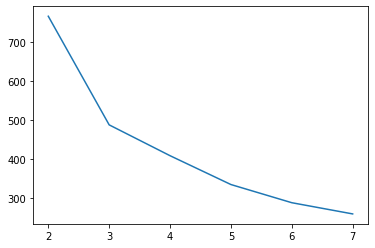

In [21]:
ssd = []
for cluster in range(2,8):
  kmeans = KMeans(n_clusters = cluster,init = 'k-means++', n_init = 10, max_iter = 300)
  kmeans.fit(country_df_scaled)
  ssd.append(kmeans.inertia_)

# plot
plt.plot(range(2,8), ssd)

Observation:
- Clearly we can see that from cluster 2 to cluster 3 , there is sudden decrease in inertia while 3 onwards there is slow variating in the curve 
- k = 3 , would be optimum 
- But we also check silhouette score
  

Silhouette Score<br>
Now we will check silhouette score to find the k value for optimum number of clusters.

for cluster 2, the silhouette score is 0.4937718168175812
for cluster 3, the silhouette score is 0.43488869063898095
for cluster 4, the silhouette score is 0.4354527551289738
for cluster 5, the silhouette score is 0.4086765539133251
for cluster 6, the silhouette score is 0.3209995353173697
for cluster 7, the silhouette score is 0.3202295249306379
for cluster 8, the silhouette score is 0.3172942291692959
for cluster 9, the silhouette score is 0.3251467864599173
for cluster 10, the silhouette score is 0.28641577561351833


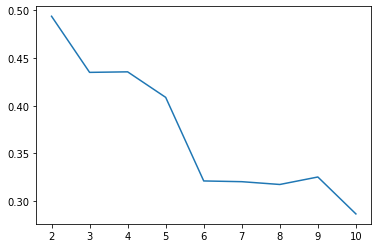

In [22]:
# silhouette score calculation for different values of cluster
sscore= []
for cluster in range(2,11):
  kmeans = KMeans(n_clusters= cluster, max_iter = 300, init ='k-means++',n_init = 10)
  kmeans.fit(country_df_scaled)
  cluster_labels = kmeans.labels_
  silhouette_avg = silhouette_score(country_df_scaled,cluster_labels)
  sscore.append(silhouette_avg)
  print("for cluster {0}, the silhouette score is {1}".format(cluster,silhouette_avg))

# plot silhouette score
plt.plot(range(2,11),sscore)

Observation:
- A higher silhouette score is better
- 2 is very less number of cluster, but it depends on requirment and one more paramenter that is elbow curve.
- k =3 and 4 has almost same silhouette score
- We will go ahead with k = 3, as k =3 is better in elbow curve.

## Step 4. Modelling Clusters with decided value of k.

In [23]:
# Final model with k = 3
kmeans = KMeans(n_clusters = 3, random_state= 100)
kmeans.fit(country_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [24]:
# adding a new column say 'label' to original dataframe
country_df['label'] = kmeans.labels_
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


In [25]:
# inspect the numbers of countries in each cluster
country_df.label.value_counts()

0    85
2    45
1    37
Name: label, dtype: int64

#### SubTask 4.2: Plotting clusters
Since we have three features , so plotting is done pairwise. The pairs are:
- child_mort and gdpp
- child_mort and income
- income and gdpp


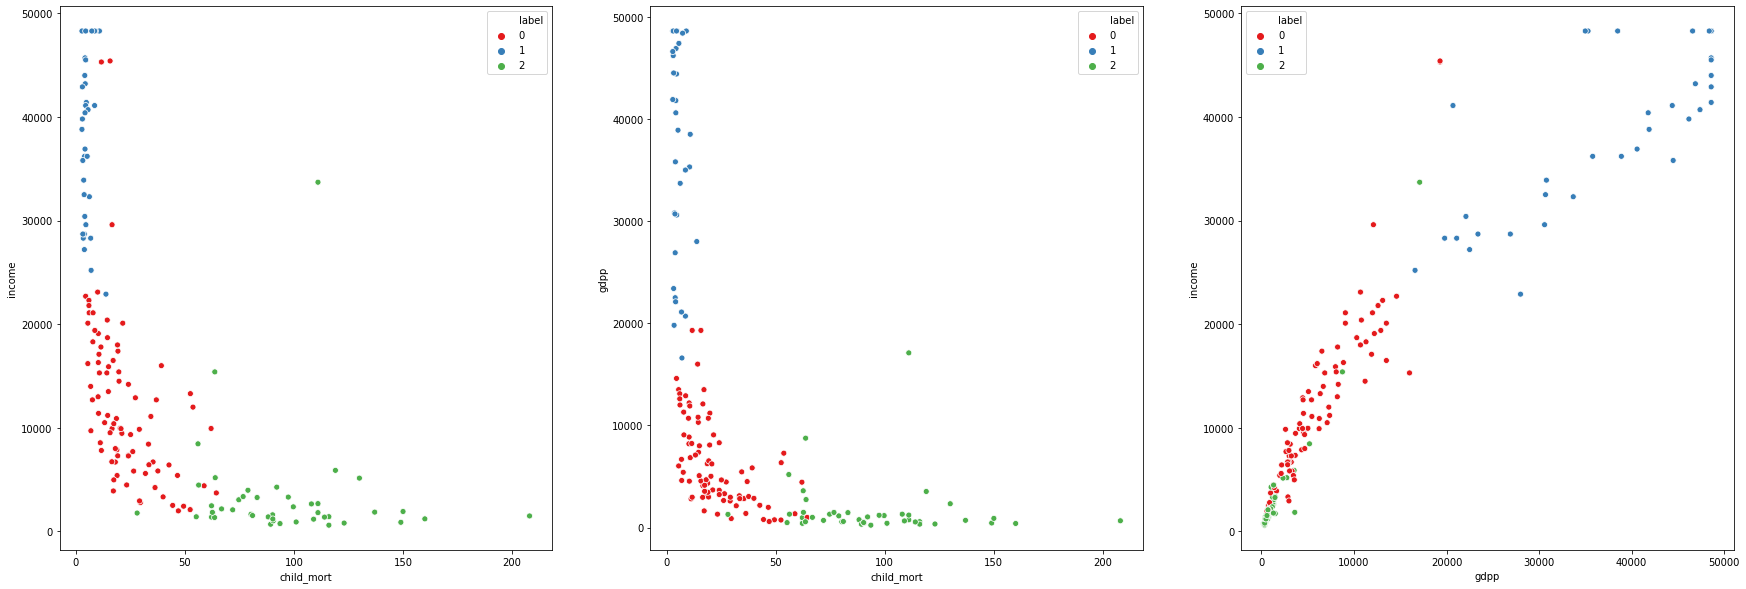

In [26]:
# cluster plot for first pair child_mort and income
fig2, axs1 = plt.subplots(1,3, figsize= [30,10])
sns.scatterplot(x= 'child_mort', y = 'income',data = country_df,hue = 'label',palette = 'Set1',ax= axs1[0])
sns.scatterplot(x= 'child_mort', y = 'gdpp', data = country_df, hue = 'label', palette = 'Set1',ax= axs1[1])
sns.scatterplot(x= 'gdpp', y = 'income', data = country_df, hue = 'label', palette = 'Set1',ax= axs1[2])
plt.show() 

Observation:
- Clearly three groups can be seen ,
- group 1 :  
    - low gdpp, low income and high child mortality
- group 2 :
    - moderate gdpp. moderate income , moderate child mortality
- group 3 :
    - high gdpp, high income and low child mortality

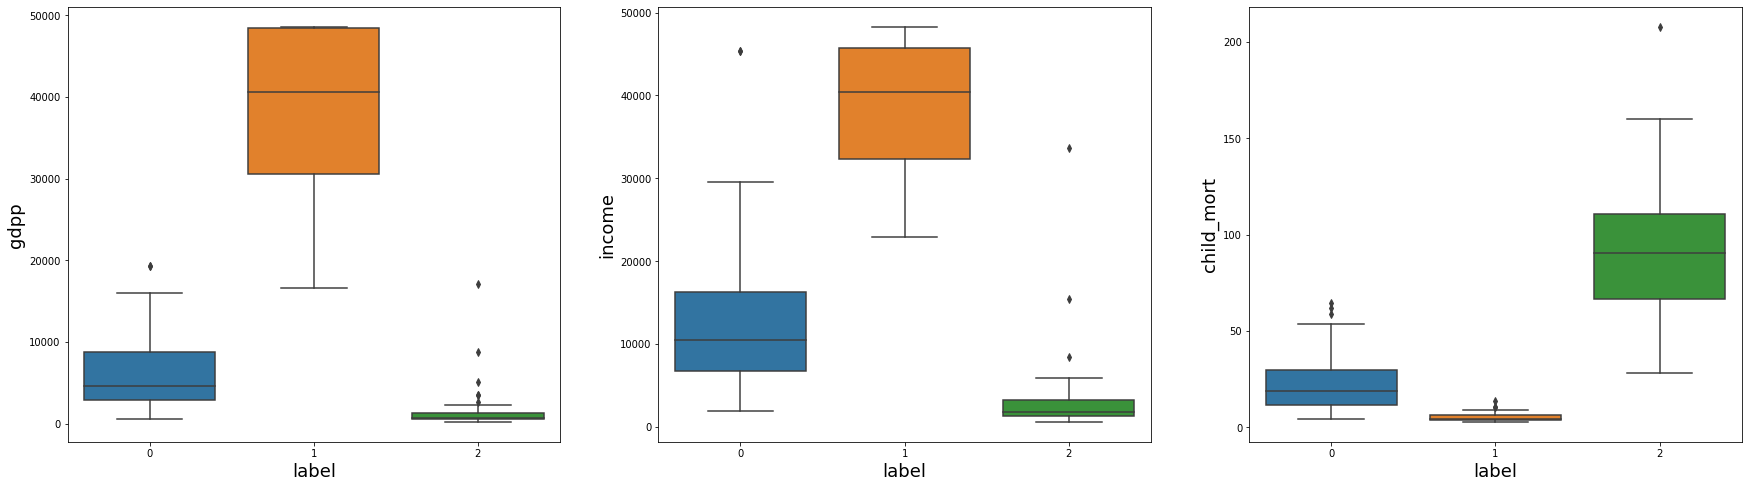

In [27]:
# analysing the group with box plot

fig, axs = plt.subplots(1,3, figsize = [30,8])
axs[0].set_xlabel('label', fontsize = '18')
axs[0].set_ylabel('gdpp', fontsize = '18')
sns.boxplot(x = 'label', y = 'gdpp', data = country_df, ax = axs[0])
axs[1].set_xlabel('income', fontsize = '18')
axs[1].set_ylabel('label', fontsize = '18')
sns.boxplot(x = 'label', y = 'income', data = country_df, ax = axs[1])
axs[2].set_xlabel('label', fontsize = '18')
axs[2].set_ylabel('child_mort', fontsize = '18')
sns.boxplot(x = 'label',y = 'child_mort', data = country_df, ax = axs[2])
plt.show()

Observation:
- In boxplot also, we can see three distinguished groups.
- Label 2 with low gdpp , low income and high child mortatlity.

## Step 5: Cluster Profiling

In [28]:
# creating new dataset groupped by cluster label
country_grouped_df = country_df.groupby('label')[['gdpp','income','child_mort']].mean()
country_grouped_df


,gdpp,income,child_mort
label,,,
0,6278.847059,12317.529412,22.860000
1,37745.675676,38711.081081,5.243243
2,1633.600000,3312.733333,94.537778


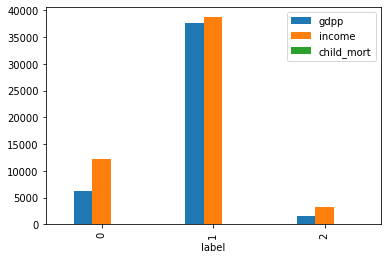

In [29]:
# anlysing their mean values
country_grouped_df.plot.bar()
plt.show()

In [30]:
# filter dataframe having label '2'
country_needs_aid = country_df[country_df['label'] == 2]
country_needs_aid.sort_values(by = ['income','gdpp','child_mort'], ascending = [True,True,False]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,2
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,2
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,2
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,2
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,2


Observation:<br>
Top 5 countries which need aid are:
- Congo,Dem Republic
- Liberia
- Burundi
- Niger
- Central African Republic

## Step 6: Hierarchical clustering

In [31]:
# inspecting scaled dataframe again
country_df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291537,-0.669581,-0.629435,-0.732729,-0.958349,0.157336,-1.619092,1.902882,-0.757362
1,-0.538993,-0.542172,-0.473489,-0.472182,-0.394006,-0.312347,0.647866,-0.859973,-0.523321
2,-0.272870,-0.475838,-0.530017,-0.560152,-0.192552,0.789274,0.670423,-0.038404,-0.498838
3,2.007831,-0.418960,-0.588935,-0.543087,-0.667360,1.387054,-1.179234,2.128151,-0.560376
4,-0.695682,-0.027134,-0.150685,0.306422,0.227992,-0.601749,0.704258,-0.541946,0.013312


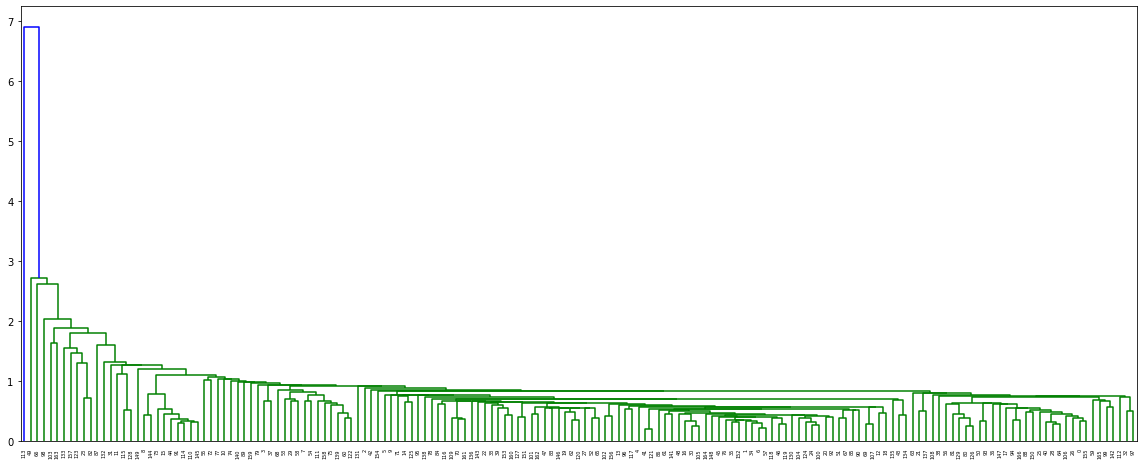

In [32]:
# single linkage
merging = linkage(country_df_scaled, method = 'single', metric = 'euclidean')
plt.figure(figsize= [20,8])
dendrogram(merging)
plt.show()

Observation:
- We cannot find a clear discrimination among different clusters
- Try for another method __complete linkage__

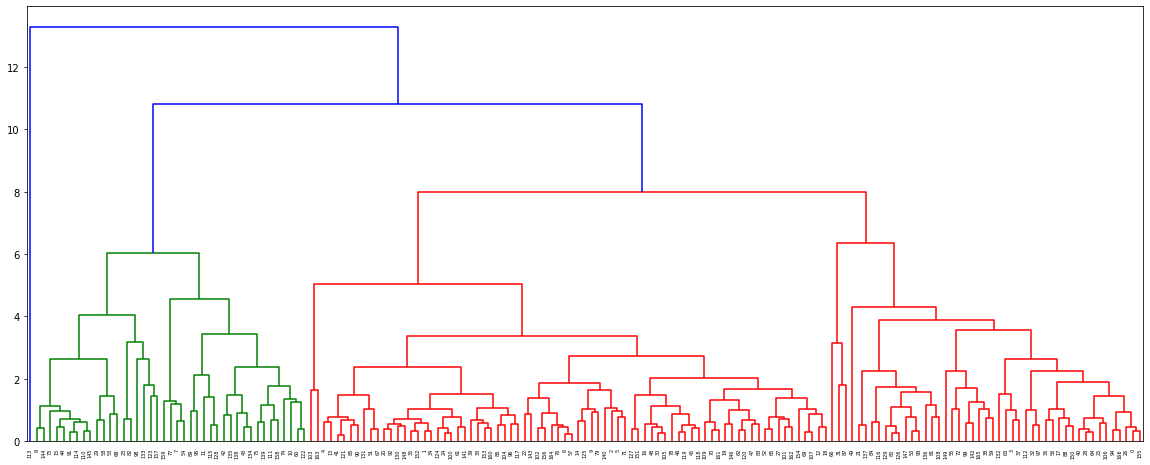

In [33]:
# complete linkage
merging2 = linkage(country_df_scaled, method = 'complete', metric = 'euclidean')
plt.figure(figsize=[20,8])
dendrogram(merging2)
plt.show()

Observation:
- Clusters are clearly visible 
- k = 3 is ok but k = 4, gives clear discrimination 

In [34]:
# cut the dendrogram in to optimum number of clusters
# reshape the array to add it in the main dataset 
cluster_complete_array = cut_tree(merging2, n_clusters = 4).reshape(-1,)
cluster_complete_array

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       2, 2, 0, 3, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [35]:
# adding label from hierarchy clsutering technique
country_df['hierarchy_label_complete'] = cluster_complete_array
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,label,hierarchy_label_complete
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0,1


In [36]:
# inspect the number of countries in each cluster
country_df['hierarchy_label_complete'].value_counts().sort_index()

0    47
1    78
2    41
3     1
Name: hierarchy_label_complete, dtype: int64

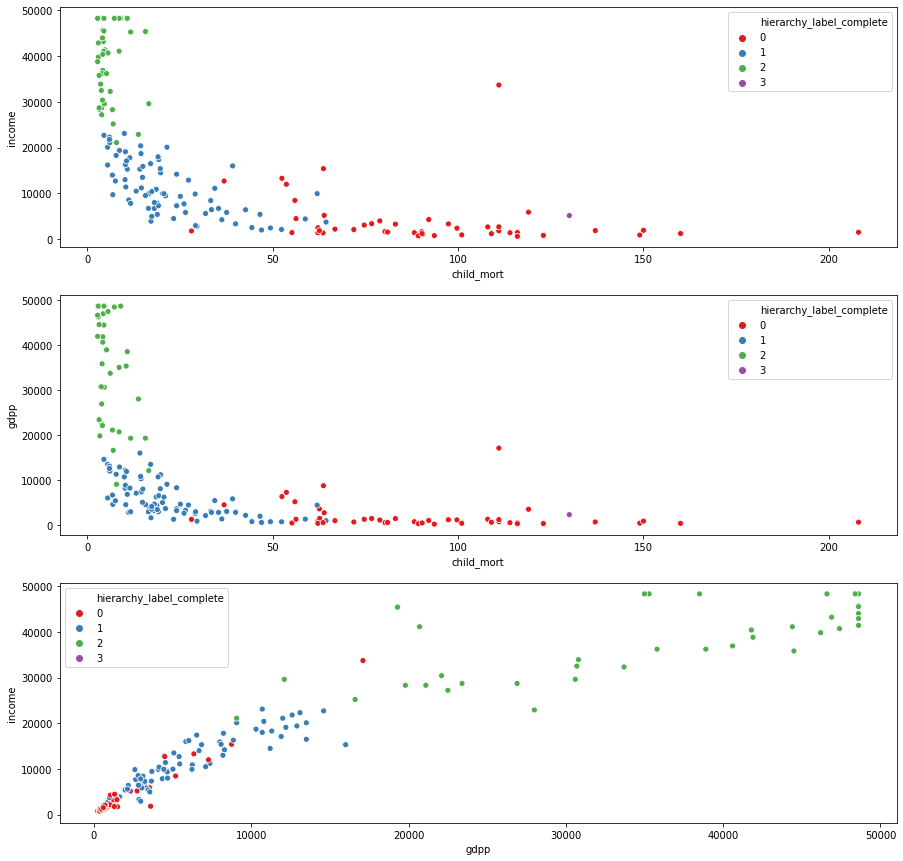

In [37]:
# analysis the different clusters
plt.figure(figsize= [15,15])
plt.subplot(3,1,1)

sns.scatterplot(x= 'child_mort', y = 'income', data = country_df, hue = 'hierarchy_label_complete',palette = 'Set1')
plt.subplot(3,1,2)
sns.scatterplot(x= 'child_mort', y = 'gdpp', data = country_df, hue = 'hierarchy_label_complete', palette = 'Set1' )
plt.subplot(3,1,3)

sns.scatterplot(x= 'gdpp', y = 'income', data = country_df, hue = 'hierarchy_label_complete', palette = 'Set1')
plt.show()

Observation:
- Clearly - label 0 has low gdpp , low income and high child mortality
- label 0 is target cluster , from where 5 countries will be picked which have serious need of aid.

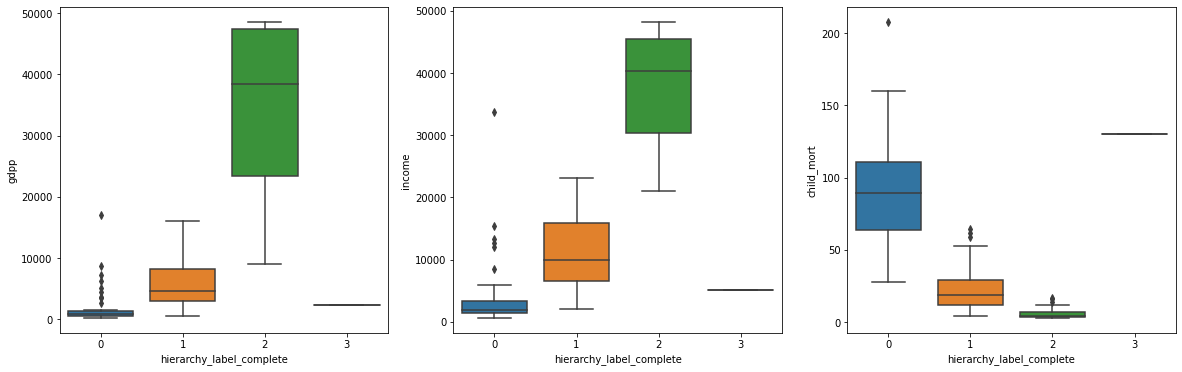

In [38]:
fig,axs = plt.subplots(1,3, figsize = [20, 6])
sns.boxplot(x = 'hierarchy_label_complete', y = 'gdpp', data = country_df, ax = axs[0] )
sns.boxplot(x = 'hierarchy_label_complete', y = 'income', data = country_df, ax = axs[1] )
sns.boxplot(x = 'hierarchy_label_complete', y = 'child_mort', data = country_df, ax = axs[2] )
plt.show()

### SubTask : Cluster Profiling in hierarchical clustering

In [41]:
# groupping on the basis of labels
country_grouped_hierarchy_df = country_df.groupby('hierarchy_label_complete')[['gdpp','income','child_mort']].mean()
country_grouped_hierarchy_df

,gdpp,income,child_mort
hierarchy_label_complete,,,
0,1900.255319,3870.702128,90.793617
1,5843.615385,11122.948718,22.411538
2,35520.975610,38383.170732,5.997561
3,2330.000000,5150.000000,130.000000


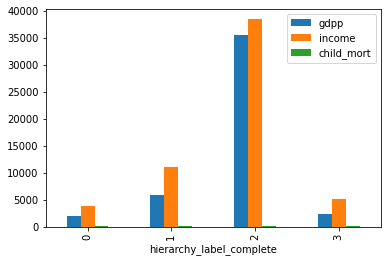

In [42]:
# plotting mean value of groupped clusters
country_grouped_hierarchy_df.plot.bar()

In [44]:
# final selecting of top 5 countries
country_needs_aid_complete_hierarchy = country_df[country_df['hierarchy_label_complete'] == 0][['country','income','gdpp','child_mort']]
country_needs_aid_complete_hierarchy.sort_values(by =['income', 'gdpp','child_mort'], ascending = [True, True,False]).head()

,country,income,gdpp,child_mort
37,"Congo, Dem. Rep.",609.0,334.0,116.0
88,Liberia,700.0,327.0,89.3
26,Burundi,764.0,231.0,93.6
112,Niger,814.0,348.0,123.0
31,Central African Republic,888.0,446.0,149.0


Observation:<br>
Getting same 5 countries as in kmean clustering

### Recommendation:
The top 5 countries which are in serious need of aid are:
1. Congo, Dem. Rep.
2. Liberia
3. Burundi	
4. Niger	
5. Central African Republic	 